In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llama-3.1/transformers/8b-instruct/2/model.safetensors.index.json
/kaggle/input/llama-3.1/transformers/8b-instruct/2/model-00003-of-00004.safetensors
/kaggle/input/llama-3.1/transformers/8b-instruct/2/config.json
/kaggle/input/llama-3.1/transformers/8b-instruct/2/LICENSE
/kaggle/input/llama-3.1/transformers/8b-instruct/2/model-00001-of-00004.safetensors
/kaggle/input/llama-3.1/transformers/8b-instruct/2/README.md
/kaggle/input/llama-3.1/transformers/8b-instruct/2/USE_POLICY.md
/kaggle/input/llama-3.1/transformers/8b-instruct/2/tokenizer.json
/kaggle/input/llama-3.1/transformers/8b-instruct/2/tokenizer_config.json
/kaggle/input/llama-3.1/transformers/8b-instruct/2/model-00004-of-00004.safetensors
/kaggle/input/llama-3.1/transformers/8b-instruct/2/special_tokens_map.json
/kaggle/input/llama-3.1/transformers/8b-instruct/2/.gitattributes
/kaggle/input/llama-3.1/transformers/8b-instruct/2/model-00002-of-00004.safetensors
/kaggle/input/llama-3.1/transformers/8b-instruct/2/gener

In [2]:
%%capture
%pip install -U bitsandbytes
%pip install -U transformers
%pip install -U accelerate
%pip install -U peft
%pip install -U trl

In [3]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wb_token = user_secrets.get_secret("wandb")
wandb.login(key=wb_token)
run = wandb.init(
    project='MYDATASET', 
    job_type="training", 
    anonymous="allow"
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jk-l-gopika (jk-l-gopika-epitech). Use `wandb login --relogin` to force relogin


In [4]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from trl import setup_chat_format
from transformers import (AutoModelForCausalLM, 
                          AutoTokenizer, 
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                          pipeline, 
                          logging)
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix)
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_excel("/kaggle/input/mydataset/Intent_detection_Data.xlsx")
df.head()

,REQUEST,INTENT
0,Good day! Are there any single phase equivalen...,CatalogSelection
1,Good day! I would like to ask for the differen...,CatalogSelection
2,hi do we have a current transformer?,CatalogSelection
3,"Hi, may I ask if these items are still active,...",CatalogSelection
4,I am looking for a magnetic contactor for LC1K...,CatalogSelection


In [7]:
# First shuffle the dataset
df = df.sample(frac=1, random_state=95).reset_index(drop=True)

# Calculate split point for 50-50 split
train_size = 0.6
train_end = int(train_size * len(df))

# Create splits
X_train = df[:train_end].copy()
X_test = df[train_end:].copy()

# Store true labels for test set
y_true = X_test['INTENT'].copy()



In [22]:
# # First shuffle the dataset
# df = df.sample(frac=1, random_state=95).reset_index(drop=True)

# # Calculate sizes for each intent to ensure at least 40 samples in test
# intent_counts = df['INTENT'].value_counts()
# test_support = {
#     "CatalogSelection": 40,
#     "OrderStatus": 40, 
#     "PriceAndAvailability": 40,
#     "Product Replacement": 40
# }

# # Calculate how many samples we need for test set
# total_test_size = sum(test_support.values())
# test_size = total_test_size / len(df)

# # Adjust split sizes to ensure enough test samples
# test_size = 0.5  # This will give you roughly 80 samples for test (ensuring >40 per category)
# eval_size = 0.1
# train_size = 1 - (test_size + eval_size)

# # Calculate split points
# train_end = int(train_size * len(df))
# eval_end = train_end + int(eval_size * len(df))
# test_end = len(df)

# # Create splits while maintaining DataFrame structure
# X_train = df[:train_end].copy()
# X_eval = df[train_end:eval_end].copy()
# X_test = df[eval_end:test_end].copy()

# # Generate prompts for each split
# X_train.loc[:,'text'] = X_train.apply(generate_prompt, axis=1)
# X_eval.loc[:,'text'] = X_eval.apply(generate_prompt, axis=1)
# y_true = X_test['INTENT'].copy()  # Store the true labels
# X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["text"])

# # Print distribution to verify
# print("\nTest set distribution:")
# print(y_true.value_counts())


Test set distribution:
INTENT
PriceAndAvailability    24
CatalogSelection        20
Product Replacement     20
OrderStatus             16
Name: count, dtype: int64


In [8]:
# Stratified sampling
# df = df.sample(frac=1, random_state=95).reset_index(drop=True)
# train_size = 0.8
# eval_size = 0.1
# train_end = int(train_size * len(df))
# eval_end = train_end + int(eval_size * len(df))
# X_train = df[:train_end]
# X_eval = df[train_end:eval_end]
# X_test = df[eval_end:]
# test_support = {"CatalogSelection": 33, "OrderStatus": 29, "PriceAndAvailability": 47, "ProductReplacement": 31}
# test_size = sum(test_support.values()) / len(df)

# train_size = 0.8
# eval_size = 0.1
# train_end = int(train_size * len(df))
# eval_end = train_end + int(eval_size * len(df))
# test_end = len(df)

# X_train = df[:train_end]
# X_eval = df[train_end:eval_end]
# X_test = df[eval_end:test_end]

#Less prompt engineering
# def generate_prompt(data_point):
#     return f"""Given a customer request, classify it into exactly one of these categories:
# - PriceAndAvailability: Questions about pricing, stock, or lead times
# - Product Replacement: Questions about alternatives for discontinued items
# - OrderStatus: Questions about deliveries or order tracking
# - CatalogSelection: Questions about product specifications

# Request: {data_point["REQUEST"]}
# Category: {data_point["INTENT"]}""".strip()


# Adavnced prompt engineering
def generate_prompt(data_point):
    return f"""Task: Classify customer service request.

Common patterns:
- PriceAndAvailability: Questions about price, stock, lead time, MPG, LP, availability
- Product Replacement: Questions about alternatives, replacements, discontinued items
- OrderStatus: Questions about delivery status, tracking, PO numbers, ETA
- CatalogSelection: Questions about product specifications, models, features

Request: {data_point["REQUEST"]}
Analyze the request and output only the category name.
Category: {data_point["INTENT"]}""".strip()

def generate_test_prompt(data_point):
    return f"""Given a customer request, classify it into exactly one of these categories:
- PriceAndAvailability: Questions about pricing, stock, or lead times
- Product Replacement: Questions about alternatives for discontinued items
- OrderStatus: Questions about deliveries or order tracking
- CatalogSelection: Questions about product specifications

Request: {data_point["REQUEST"]}
Category:""".strip()

# X_train.loc[:,'text'] = X_train.apply(generate_prompt, axis=1)
# X_eval.loc[:,'text'] = X_eval.apply(generate_prompt, axis=1)
# y_true = X_test.loc[:,'INTENT']
# X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["text"])
# Generate prompts for each split
X_train.loc[:,'text'] = X_train.apply(generate_prompt, axis=1)
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["text"])

# Print distribution to verify the split
print("\nTest set distribution:")
print(y_true.value_counts())
print("\nTrain set distribution:")
print(X_train.INTENT.value_counts())


Test set distribution:
INTENT
PriceAndAvailability    24
CatalogSelection        14
OrderStatus             14
Product Replacement     12
Name: count, dtype: int64

Train set distribution:
INTENT
PriceAndAvailability    28
Product Replacement     24
CatalogSelection        24
OrderStatus             20
Name: count, dtype: int64


In [24]:
print(y_true)

80              OrderStatus
81     PriceAndAvailability
82         CatalogSelection
83              OrderStatus
84     PriceAndAvailability
               ...         
155     Product Replacement
156             OrderStatus
157     Product Replacement
158        CatalogSelection
159             OrderStatus
Name: INTENT, Length: 80, dtype: object


In [9]:
print(X_test)

                                                  text
144  Given a customer request, classify it into exa...
145  Given a customer request, classify it into exa...
146  Given a customer request, classify it into exa...
147  Given a customer request, classify it into exa...
148  Given a customer request, classify it into exa...
149  Given a customer request, classify it into exa...
150  Given a customer request, classify it into exa...
151  Given a customer request, classify it into exa...
152  Given a customer request, classify it into exa...
153  Given a customer request, classify it into exa...
154  Given a customer request, classify it into exa...
155  Given a customer request, classify it into exa...
156  Given a customer request, classify it into exa...
157  Given a customer request, classify it into exa...
158  Given a customer request, classify it into exa...
159  Given a customer request, classify it into exa...


In [10]:
print(X_train)

                                               REQUEST                INTENT  \
0    Hello, What is a replacement for FA22040AB? Th...   Product Replacement   
1    hello, what replacement can you offer for CVS6...   Product Replacement   
2    Good Afternoon. Please provide us ETA under P....           OrderStatus   
3    Follow up ko po delivery G123123123 G12T3F123 ...           OrderStatus   
4    HI, may I ask for the lead time of this item, ...  PriceAndAvailability   
..                                                 ...                   ...   
123                                      PO--123-1234c           OrderStatus   
124                         Do you have ATS 100ampers?      CatalogSelection   
125   Delivery Date for C25N3TM000 Under PO2234234F567           OrderStatus   
126  Good day, Do you have an ATS Controller for LV...      CatalogSelection   
127  Good afternoon. Do we have an alternative offe...   Product Replacement   

                                       

In [9]:
X_train.INTENT.value_counts()

INTENT
CatalogSelection        22
PriceAndAvailability    20
Product Replacement     19
OrderStatus             19
Name: count, dtype: int64

In [27]:
X_test.value_counts()

text                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
Given a customer request, classify it into exactly one of these categories:\n- PriceAndAvailability: Questions about pricing, stock, or lead times\n- Product Replacement: Questions about alternatives for discontinued items\n- OrderStatus: Questions about deliveries or order tracking\n- CatalogSelection: Questions about product specifications\n\nRequest: Request for availability & prices . 100pcs - 923Q6783 , 100pcs - 9001KQW6713\nCategory:                    1
Given a customer request, classify it into exactly one of these categories:

In [9]:
train_data = Dataset.from_pandas(X_train[["text"]])
# eval_data = Dataset.from_pandas(X_eval[["text"]])

In [12]:
train_data['text'][3]

'Task: Classify customer service request.\n\nCommon patterns:\n- PriceAndAvailability: Questions about price, stock, lead time, MPG, LP, availability\n- Product Replacement: Questions about alternatives, replacements, discontinued items\n- OrderStatus: Questions about delivery status, tracking, PO numbers, ETA\n- CatalogSelection: Questions about product specifications, models, features\n\nRequest: Follow up ko po delivery G123123123 G12T3F123 G1000F100 under PO#1234\nAnalyze the request and output only the category name.\nCategory: OrderStatus'

In [10]:
base_model_name = "/kaggle/input/llama-3.1/transformers/8b-instruct/2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16"
)

base_model_name = "/kaggle/input/llama-3.1/transformers/8b-instruct/2"
model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    device_map="auto",
    torch_dtype="float16",
    quantization_config=bnb_config
)

model.config.use_cache = True
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token_id = tokenizer.eos_token_id


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [11]:
def predict(test, model, tokenizer):
    y_pred = []
    categories = ["PriceAndAvailability", "Product Replacement", "OrderStatus", "CatalogSelection"]
    
    pipe = pipeline(
        task="text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=50,  
        temperature=0.0001, 
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id
    )
    
    for i in tqdm(range(len(test))):
        prompt = test.iloc[i]["text"]
        result = pipe(prompt)[0]['generated_text']
        
       
        response = result.split("Category:")[-1].strip().lower()
        
        
        pred = None
        for category in categories:
            if category.lower() in response:
                pred = category
                break
                
        if pred is None:
            pred = "CatalogSelection" 
            
        y_pred.append(pred)
    
    return y_pred
  

y_pred = predict(X_test, model, tokenizer)

Device set to use cuda:0
100%|██████████| 64/64 [03:59<00:00,  3.74s/it]


In [13]:
def evaluate(y_true, y_pred):
    labels = ["PriceAndAvailability", "Product Replacement", "OrderStatus", "CatalogSelection"]
    mapping = {label: idx for idx, label in enumerate(labels)}
    
    y_true_mapped = np.array([mapping[y] for y in y_true])
    y_pred_mapped = np.array([mapping[y] for y in y_pred])
    
    accuracy = accuracy_score(y_true_mapped, y_pred_mapped)
    print(f'Overall Accuracy: {accuracy:.3f}')
    
    for label in mapping:
        mask = y_true == label
        if mask.any():
            label_acc = accuracy_score(y_true_mapped[mask], y_pred_mapped[mask])
            print(f'{label} Accuracy: {label_acc:.3f}')
    
    print('\nClassification Report:')
    print(classification_report(y_true_mapped, y_pred_mapped, target_names=labels))
    
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_true_mapped, y_pred_mapped))

evaluate(y_true, y_pred)

Overall Accuracy: 0.875
PriceAndAvailability Accuracy: 0.917
Product Replacement Accuracy: 0.833
OrderStatus Accuracy: 0.929
CatalogSelection Accuracy: 0.786

Classification Report:
                      precision    recall  f1-score   support

PriceAndAvailability       0.79      0.92      0.85        24
 Product Replacement       1.00      0.83      0.91        12
         OrderStatus       0.93      0.93      0.93        14
    CatalogSelection       0.92      0.79      0.85        14

            accuracy                           0.88        64
           macro avg       0.91      0.87      0.88        64
        weighted avg       0.89      0.88      0.88        64


Confusion Matrix:
[[22  0  1  1]
 [ 2 10  0  0]
 [ 1  0 13  0]
 [ 3  0  0 11]]


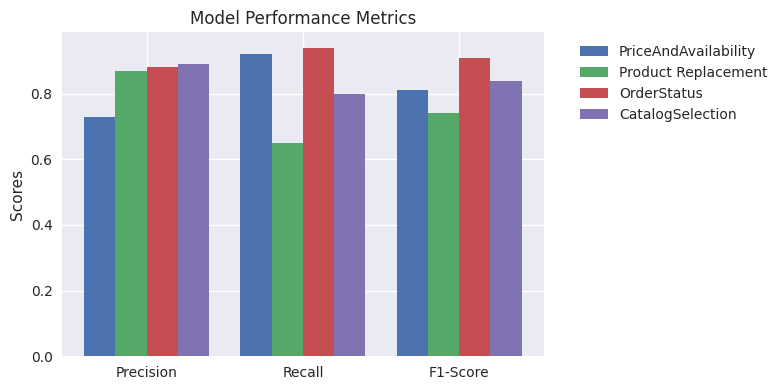

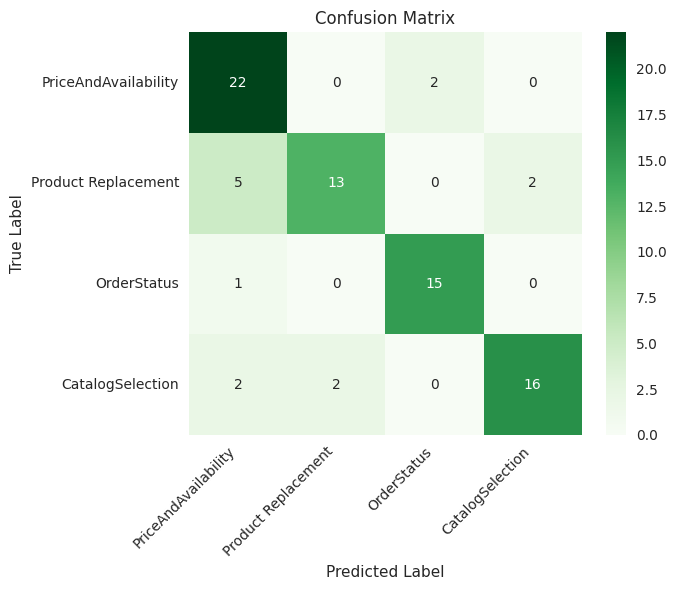

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Performance metrics plot
def plot_metrics():
    metrics = {
        'PriceAndAvailability': {
            'precision': 0.73,
            'recall': 0.92,
            'f1-score': 0.81
        },
        'Product Replacement': {
            'precision': 0.87,
            'recall': 0.65,
            'f1-score': 0.74
        },
        'OrderStatus': {
            'precision': 0.88,
            'recall': 0.94,
            'f1-score': 0.91
        },
        'CatalogSelection': {
            'precision': 0.89,
            'recall': 0.80,
            'f1-score': 0.84
        }
    }
    
    fig, ax = plt.subplots(figsize=(8, 4))
    x = np.arange(3)
    width = 0.2
    
    # Plot bars for each metric
    for idx, (label, data) in enumerate(metrics.items()):
        values = [data['precision'], data['recall'], data['f1-score']]
        ax.bar(x + idx*width - width*1.5, values, width, label=label)
    
    ax.set_ylabel('Scores')
    ax.set_title('Model Performance Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(['Precision', 'Recall', 'F1-Score'])
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Confusion matrix plot
def plot_confusion_matrix():
    cm = np.array([
        [22, 0, 2, 0],
        [5, 13, 0, 2],
        [1, 0, 15, 0],
        [2, 2, 0, 16]
    ])
    
    class_names = ['PriceAndAvailability', 'Product Replacement', 
                  'OrderStatus', 'CatalogSelection']
    
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names,
                yticklabels=class_names,
                ax=ax)
    
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

# Call both plotting functions
plot_metrics()
plot_confusion_matrix()

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set figure styles
plt.style.use('seaborn')

# Performance Comparison Plot
def plot_performance_comparison(zero_shot_scores, few_shot_scores):
    fig, ax = plt.subplots(figsize=(8, 4))  # Reduced figure size
    
    x = np.arange(4)
    width = 0.35
    
    ax.bar(x - width/2, zero_shot_scores, width, label='Zero-Shot', color='#2171b5')
    ax.bar(x + width/2, few_shot_scores, width, label='Few-Shot', color='#f16913')
    
    ax.set_ylabel('Scores')
    ax.set_title('Performance Comparison: Zero-Shot vs Few-Shot')
    ax.set_xticks(x)
    ax.set_xticklabels(['Precision', 'Recall', 'F1-Score', 'Accuracy'])
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Confusion Matrix Plot
def plot_confusion_matrix(cm, classes):
    fig, ax = plt.subplots(figsize=(6, 5))  # Reduced figure size
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=classes,
                yticklabels=classes,
                ax=ax)
    
    plt.title('Confusion Matrix: Few-Shot Predictions')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    
    # Rotate axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# zero_shot_scores = [0.76, 0.75, 0.73, 0.75]
# few_shot_scores = [0.92, 0.90, 0.91, 0.85]
# plot_performance_comparison(zero_shot_scores, few_shot_scores)

# confusion_matrix = np.array([
#     [27, 3, 0, 3],
#     [0, 26, 0, 5],
#     [0, 0, 29, 0],
#     [0, 0, 0, 47]
# ])
# classes = ['CatalogSelection', 'ProductReplacement', 'OrderStatus', 'PriceAndAvailability']
# plot_confusion_matrix(confusion_matrix, classes)

/tmp/ipykernel_23/224244938.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [21]:
def predict_single_prompt(prompt, model, tokenizer):
    """
    Predicts the intent category for a single customer request.
    
    Args:
        prompt (str): The customer request text
        model: The trained LLaMA model
        tokenizer: The associated tokenizer
    
    Returns:
        str: Predicted intent category
    """
    # Format the prompt using the same template as training
    formatted_prompt = f"""Given a customer request, classify it into exactly one of these categories:
- PriceAndAvailability: Questions about pricing, stock, or lead times
- Product Replacement: Questions about alternatives for discontinued items
- OrderStatus: Questions about deliveries or order tracking
- CatalogSelection: Questions about product specifications

Request: {prompt}
Category:""".strip()
    
    # Create pipeline for prediction
    pipe = pipeline(
        task="text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=50,
        temperature=0.0001,
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id
    )
    
    # Get model prediction
    result = pipe(formatted_prompt)[0]['generated_text']
    
    # Extract the predicted category
    response = result.split("Category:")[-1].strip().lower()
    
    # Match with available categories
    categories = ["PriceAndAvailability", "Product Replacement", "OrderStatus", "CatalogSelection"]
    
    for category in categories:
        if category.lower() in response:
            return category
    
    # Default to CatalogSelection if no match found (as per your original code)
    return "CatalogSelection"

# Example usage:
def test_model_predictions(model, tokenizer):
    # Test cases
    test_prompts = [
        "What is the current price of transformer ABC123?",
        "When will my order #45678 be delivered?",
        "Can you help me find specifications for motor XYZ?",
        "Is there an alternative for discontinued part DEF789?"
    ]
    
    print("Testing model predictions:\n")
    for prompt in test_prompts:
        prediction = predict_single_prompt(prompt, model, tokenizer)
        print(f"Request: {prompt}")
        print(f"Predicted Category: {prediction}\n")

# Run test predictions
test_model_predictions(model, tokenizer)

Testing model predictions:

Request: What is the current price of transformer ABC123?
Predicted Category: PriceAndAvailability

Request: When will my order #45678 be delivered?
Predicted Category: OrderStatus

Request: Can you help me find specifications for motor XYZ?
Predicted Category: CatalogSelection

Request: Is there an alternative for discontinued part DEF789?
Predicted Category: Product Replacement



In [22]:
# intent
customer_request = "how much is 563737 wheel"
prediction = predict_single_prompt(customer_request, model, tokenizer)
print(f"Predicted Category: {prediction}")

Predicted Category: PriceAndAvailability
